# DA5401 A8: Ensemble Learning for Complex Regression Modeling on Bike Share Data

**Objective:** This notebook aims to solve a complex, time-series-based regression problem by applying and comparing three primary ensemble techniques: Bagging, Boosting, and Stacking. We will analyze how these methods address model variance and bias to achieve superior predictive performance on the Bike Sharing Demand Dataset.

- **Student:** Venkata Sai Vishwesvar SV
- **Roll Number:** BE22B042

---

## 1. Problem Statement and Methodology

### Business Context
As a data scientist for a city's bike-sharing program, our goal is to accurately forecast the total count of rented bikes (`cnt`) on an hourly basis. This is a critical task for the operational efficiency of the program. Accurate demand prediction enables effective inventory management (ensuring bikes are available where and when they are needed), informs logistical decisions about bike redistribution, helps in planning maintenance schedules, and ultimately improves user satisfaction.

### The Challenge
The prediction is complex due to its dependence on a multitude of interacting factors. These include:
- **Temporal Patterns:** Demand varies significantly by the hour of the day (e.g., morning and evening commutes), day of the week (weekdays vs. weekends), and month of the year (seasonal changes).
- **Environmental Factors:** Weather conditions like temperature, humidity, and wind speed play a crucial role in a person's decision to rent a bike.
- **Non-Linear Interactions:** The relationship between these factors is not always linear. For example, the effect of temperature on demand might be different on a holiday versus a working day.

### Our Approach: Ensemble Learning
To tackle this complexity, we will move beyond single predictive models and leverage the power of **ensemble learning**. Ensemble methods combine the predictions of multiple base models to produce a single, more robust, and accurate prediction. The core idea is that a diverse group of models, when combined, can compensate for each other's weaknesses, leading to a "wisdom of the crowd" effect.

We will implement and evaluate three distinct ensemble strategies:
1.  **Bagging (Bootstrap Aggregating):** A technique primarily aimed at **reducing variance**. It works by training multiple base models on different random subsets of the training data and averaging their predictions. This helps to create a more stable model that is less sensitive to the specific training data it was fitted on.
2.  **Boosting:** A sequential technique primarily aimed at **reducing bias**. It builds models one after another, where each subsequent model focuses on correcting the errors made by its predecessors. This results in a powerful model that can capture very complex patterns in the data.
3.  **Stacking (Stacked Generalization):** A hierarchical technique that aims to find the optimal way to combine predictions from multiple, diverse models. It uses a set of base models (Level 0) to generate predictions, which are then used as input features for a final meta-model (Level 1) that makes the ultimate prediction.

Our success will be measured by the **Root Mean Squared Error (RMSE)**, a standard metric for regression tasks that penalizes larger errors more heavily. Our goal is to minimize this value, indicating a closer fit between our model's predictions and the actual bike rental counts.

### Dataset Information
- **Dataset:** Bike Sharing Demand Dataset (Hourly Data)
- **Citation:** Fanaee-T, Hadi, and Gamper, H. (2014). Bikeshare Data Set. UCI Machine Learning Repository.
- **Download Link:** [UCI Machine Learning Repository - Bike Sharing Dataset](https://archive.ics.uci.edu/ml/datasets/bike+sharing+dataset)

---

## Part A: Data Preprocessing and Baseline [10 points]

This section covers the essential preliminary steps: loading the data, cleaning and transforming it into a suitable format for modeling, and establishing a baseline performance metric using single regression models. This baseline will serve as a benchmark against which we will compare our more sophisticated ensemble models.

### Initial Setup: Importing Libraries

First, let's import all the necessary libraries. We'll need `pandas` and `numpy` for data manipulation, `matplotlib` and `seaborn` for visualization, and a suite of tools from `scikit-learn` for preprocessing, modeling, and evaluation.

In [39]:
# Data Manipulation and Analysis
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-Learn for Preprocessing and Modeling
from sklearn.model_selection import train_test_split, RandomizedSearchCV

# Regression Models
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import BaggingRegressor, GradientBoostingRegressor, StackingRegressor

# Evaluation Metric
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')


# Setting plot styles for better aesthetics
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

### 1. Data Loading and Feature Engineering

#### Load and Inspect the Data
We begin by loading the `hour.csv` file into a pandas DataFrame and performing an initial inspection to understand its structure, data types, and check for missing values.

In [40]:
# Load the dataset
df = pd.read_csv('hour.csv')

# Display the first few rows and general information
print("First 5 rows of the dataset:")
display(df.head())
print("\nDataset Information:")
df.info()

First 5 rows of the dataset:


,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1



Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     17379 non-null  int64  
 1   dteday      17379 non-null  object 
 2   season      17379 non-null  int64  
 3   yr          17379 non-null  int64  
 4   mnth        17379 non-null  int64  
 5   hr          17379 non-null  int64  
 6   holiday     17379 non-null  int64  
 7   weekday     17379 non-null  int64  
 8   workingday  17379 non-null  int64  
 9   weathersit  17379 non-null  int64  
 10  temp        17379 non-null  float64
 11  atemp       17379 non-null  float64
 12  hum         17379 non-null  float64
 13  windspeed   17379 non-null  float64
 14  casual      17379 non-null  int64  
 15  registered  17379 non-null  int64  
 16  cnt         17379 non-null  int64  
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB


#### Data Cleaning and Preparation
From the initial inspection, we can identify columns that are not suitable for direct use in the model.
- `instant`: This is just a row index and provides no predictive information.
- `dteday`: The date information is already captured by the `yr`, `mnth`, `weekday`, and `hr` columns.
- `casual` and `registered`: These two columns sum up to our target variable, `cnt`. Including them in our features would be **data leakage**, as the model would learn to simply add them together to predict the target perfectly, making it useless for predicting future, unseen data where these values are not known.

We will drop these columns.

In [41]:
# Drop specified columns
df_processed = df.drop(columns=['instant', 'dteday', 'casual', 'registered'])

print("Columns after dropping irrelevant ones:", df_processed.columns.tolist())

Columns after dropping irrelevant ones: ['season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'cnt']


#### Feature Transformation: One-Hot Encoding
Machine learning models require all input features to be numeric. Our dataset contains several categorical features (`season`, `yr`, `mnth`, `hr`, `weekday`, `weathersit`) that are encoded as integers. Leaving them as is could mislead the model into assuming an ordinal relationship (e.g., that month 2 is "twice" month 1).

To handle this, we use **One-Hot Encoding**, which converts each categorical value into a new binary column (0 or 1). We set `drop_first=True` to remove one column from each new set of dummy variables, which helps prevent multicollinearity without losing any information.

In [42]:
# Identify categorical columns
categorical_features = ['season', 'yr', 'mnth', 'hr', 'weekday', 'weathersit']

# Apply One-Hot Encoding
df_processed = pd.get_dummies(df_processed, columns=categorical_features, drop_first=True)

print("Shape of the dataframe after One-Hot Encoding:", df_processed.shape)
print("\nFirst 5 rows of the processed dataset:")
display(df_processed.head())

Shape of the dataframe after One-Hot Encoding: (17379, 54)

First 5 rows of the processed dataset:


,holiday,workingday,temp,atemp,hum,windspeed,cnt,season_2,season_3,season_4,...,hr_23,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weathersit_2,weathersit_3,weathersit_4
0,0,0,0.24,0.2879,0.81,0.0,16,False,False,False,...,False,False,False,False,False,False,True,False,False,False
1,0,0,0.22,0.2727,0.80,0.0,40,False,False,False,...,False,False,False,False,False,False,True,False,False,False
2,0,0,0.22,0.2727,0.80,0.0,32,False,False,False,...,False,False,False,False,False,False,True,False,False,False
3,0,0,0.24,0.2879,0.75,0.0,13,False,False,False,...,False,False,False,False,False,False,True,False,False,False
4,0,0,0.24,0.2879,0.75,0.0,1,False,False,False,...,False,False,False,False,False,False,True,False,False,False


### 2. Data Splitting and Baseline Model Establishment

#### Splitting the Data
To evaluate our models' performance on unseen data and prevent overfitting, we must split our dataset into a training set and a testing set. We will use 80% of the data for training the models and the remaining 20% for testing. Setting a `random_state` ensures that this split is reproducible.

In [43]:
# Separate features (X) and target (y)
X = df_processed.drop('cnt', axis=1)
y = df_processed['cnt']

# Split the data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

print(f"Training set shape: X_train={X_train.shape}, y_train={y_train.shape}")
print(f"Testing set shape: X_test={X_test.shape}, y_test={y_test.shape}")

Training set shape: X_train=(13903, 53), y_train=(13903,)
Testing set shape: X_test=(3476, 53), y_test=(3476,)


#### Establishing Baseline Performance
Before building complex ensemble models, it is crucial to establish a **baseline performance**. A baseline is a simple, interpretable model that provides a benchmark. Any complex model we build must perform significantly better than this baseline to be considered valuable.

We will use two common models for our baseline:
1.  **Linear Regression:** A simple model that assumes a linear relationship between features and the target.
2.  **Decision Tree Regressor:** A non-linear model that learns simple decision rules. We will limit its `max_depth` to prevent severe overfitting. This model is also a natural choice as it will serve as the base estimator for our Bagging ensemble.

We will train both models and select the one with the lower RMSE as our official baseline for this project.

In [44]:
# Initialize the models
linear_model = LinearRegression()
dt_model = DecisionTreeRegressor(max_depth=6, random_state=123)

# Train the models
linear_model.fit(X_train, y_train)
dt_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_linear = linear_model.predict(X_test)
y_pred_dt = dt_model.predict(X_test)

# Calculate RMSE for both models
rmse_linear = np.sqrt(mean_squared_error(y_test, y_pred_linear))
rmse_dt = np.sqrt(mean_squared_error(y_test, y_pred_dt))

print(f"Linear Regression RMSE: {rmse_linear:.4f}")
print(f"Decision Tree (max_depth=6) RMSE: {rmse_dt:.4f}")

# Determine the baseline model
if rmse_dt < rmse_linear:
    baseline_rmse = rmse_dt
    baseline_model_name = "Decision Tree Regressor"
    print(f"\nBaseline Model: {baseline_model_name} with RMSE = {baseline_rmse:.4f}")
else:
    baseline_rmse = rmse_linear
    baseline_model_name = "Linear Regression"
    print(f"\nBaseline Model: {baseline_model_name} with RMSE = {baseline_rmse:.4f}")

Linear Regression RMSE: 103.3000
Decision Tree (max_depth=6) RMSE: 122.0250

Baseline Model: Linear Regression with RMSE = 103.3000


## Part B: Bagging for Variance Reduction

### Introduction to Bagging
Bagging, short for **Bootstrap Aggregating**, is an ensemble technique designed to improve the stability and accuracy of machine learning algorithms. Its primary goal is to **reduce variance** and combat overfitting, which is particularly useful for high-variance models like unconstrained decision trees.

The process involves two main steps:
1.  **Bootstrap:** Multiple random samples (with replacement) are drawn from the training dataset. This means some data points may appear multiple times in a sample, while others may not appear at all.
2.  **Aggregate:** A base estimator (in our case, a `DecisionTreeRegressor`) is trained independently on each bootstrap sample. The final prediction is made by averaging the predictions of all the individual estimators.

By averaging the outputs, the idiosyncrasies and noise learned by each individual tree are smoothed out, resulting in a more generalized and robust model.

### Implementation and Evaluation

We will now implement a `BaggingRegressor`. We use the `DecisionTreeRegressor` (with `max_depth=6`) as our base estimator and create an ensemble of 60 such trees. `n_jobs=-1` is used to leverage all available CPU cores for faster computation.

In [45]:
# Initialize the Decision Tree base estimator
base_estimator = DecisionTreeRegressor(max_depth=6, random_state=123)

# Initialize the Bagging Regressor
# n_jobs=-1 will use all available CPU cores for faster training
bagging_model = BaggingRegressor(
    estimator=base_estimator,
    n_estimators=60,
    random_state=123,
    n_jobs=-1
)

# Train the model
bagging_model.fit(X_train, y_train)

# Make predictions
y_pred_bagging = bagging_model.predict(X_test)

# Calculate RMSE
rmse_bagging = np.sqrt(mean_squared_error(y_test, y_pred_bagging))

print(f"Single Decision Tree RMSE (Baseline): {baseline_rmse:.4f}")
print(f"Bagging Regressor RMSE: {rmse_bagging:.4f}")

Single Decision Tree RMSE (Baseline): 103.3000
Bagging Regressor RMSE: 115.9677


## Part C: Boosting for Bias Reduction

### Introduction to Boosting
Boosting is a powerful ensemble technique that builds models in a sequential fashion. Unlike Bagging, where models are built independently, each model in a boosting ensemble is built to correct the mistakes of the previous one. This iterative process allows the model to focus on the most difficult-to-predict data points, thereby **reducing bias** and creating a very strong predictive model.

We will use **Gradient Boosting**, a popular boosting algorithm. It works as follows:
1.  An initial simple model is trained (e.g., predicting the mean of the target variable).
2.  The errors (residuals) of this model are calculated.
3.  A new model (typically a small decision tree) is trained to predict these residuals.
4.  The predictions of this new model are added to the predictions of the previous model, scaled by a `learning_rate`.
5.  This process is repeated for a specified number of estimators, with each new tree trying to correct the remaining error.

### Implementation and Evaluation
We will implement a `GradientBoostingRegressor`. Key hyperparameters include `n_estimators` (the number of sequential trees), `learning_rate` (which controls the contribution of each tree), and `max_depth` (the complexity of each individual tree). Fine-tuning these parameters is key to achieving optimal performance without overfitting.

In [46]:
# Initialize the Gradient Boosting Regressor
gbr_model = GradientBoostingRegressor(
    n_estimators=120,  # More estimators for better performance
    learning_rate=0.08, # Controls the contribution of each tree
    max_depth=6,       # Controls complexity of individual trees
    random_state=123
)

# Train the model
gbr_model.fit(X_train, y_train)

# Make predictions  
y_pred_gbr = gbr_model.predict(X_test)

# Calculate RMSE
rmse_gbr = np.sqrt(mean_squared_error(y_test, y_pred_gbr))

print(f"Single Decision Tree RMSE (Baseline): {baseline_rmse:.4f}")
print(f"Bagging Regressor RMSE: {rmse_bagging:.4f}")
print(f"Gradient Boosting Regressor RMSE: {rmse_gbr:.4f}")

Single Decision Tree RMSE (Baseline): 103.3000
Bagging Regressor RMSE: 115.9677
Gradient Boosting Regressor RMSE: 56.4635


## Part D: Stacking for Optimal Prediction Combination

### Introduction to Stacking
Stacking, or Stacked Generalization, is an advanced ensemble technique that combines multiple different types of models to leverage their individual strengths. It operates on a two-level architecture:

1.  **Level 0 (Base Learners):** A set of diverse models are trained on the full training dataset. The key to successful stacking is to use a variety of models (e.g., linear models, tree-based models, instance-based models) that learn different aspects of the data.
2.  **Level 1 (Meta-Learner):** Another model, the meta-learner, is trained on the outputs (predictions) of the base learners. To prevent data leakage, the training data for the meta-learner is typically generated using cross-validation. The meta-learner's job is to learn the optimal way to combine the predictions from the base models to produce the final, improved prediction.

### Implementation and Evaluation
We will construct a stacking ensemble with a diverse set of base learners:
- `KNeighborsRegressor`: An instance-based model.
- `BaggingRegressor`: Our previously defined variance-reduction ensemble.
- `GradientBoostingRegressor`: Our previously defined bias-reduction ensemble.

For the meta-learner, we will use `Ridge` regression, a simple and regularized linear model. This is a common choice as it is less prone to overfitting on the (often correlated) predictions from the base learners.

In [47]:
# Define the base learners
# We will use the already tuned/defined models from previous parts
base_learners = [
    ('knn', KNeighborsRegressor(n_neighbors=12)),
    ('bagging', BaggingRegressor(estimator=DecisionTreeRegressor(max_depth=6, random_state=123), n_estimators=60, random_state=123, n_jobs=-1)),
    ('gbr', GradientBoostingRegressor(n_estimators=120, learning_rate=0.08, max_depth=6, random_state=123))
]

# Define the meta-learner
meta_learner = Ridge(random_state=123)

# Initialize the Stacking Regressor
# cv=5 means the base learners' predictions are generated using 5-fold cross-validation
stacking_model = StackingRegressor(
    estimators=base_learners,
    final_estimator=meta_learner,
    cv=5,
    n_jobs=-1
)

# Train the stacking model
# This might take a few moments
stacking_model.fit(X_train, y_train)

,estimators,"[('knn', ...), ('bagging', ...), ...]"
,final_estimator,Ridge(random_state=123)
,cv,5
,n_jobs,-1
,passthrough,False
,verbose,0
,n_neighbors,12
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2


### 2. Final Evaluation
Now, let's evaluate the performance of our complete stacking ensemble on the test set.

In [48]:
# Make predictions
y_pred_stacking = stacking_model.predict(X_test)

# Calculate RMSE
rmse_stacking = np.sqrt(mean_squared_error(y_test, y_pred_stacking))

print(f"Stacking Regressor RMSE: {rmse_stacking:.4f}")

Stacking Regressor RMSE: 54.0633


## Part E: Final Model Comparison and Conclusion

After implementing and evaluating our baseline models and three distinct ensemble strategies, we will now consolidate the results for a final comparison. This will allow us to clearly see the performance gains at each stage and draw conclusions about the effectiveness of each technique for this specific problem.

### Summary of Model Performance
Let's compile the RMSE scores of all the models into a single DataFrame and visualize the results to facilitate comparison.

Summary of Model Performance (RMSE):


,Model,RMSE
0,Stacking Regressor,54.063283
1,Gradient Boosting Regressor,56.463522
2,Linear Regression,103.300024
3,Decision Tree (Baseline),103.300024
4,Bagging Regressor,115.967667


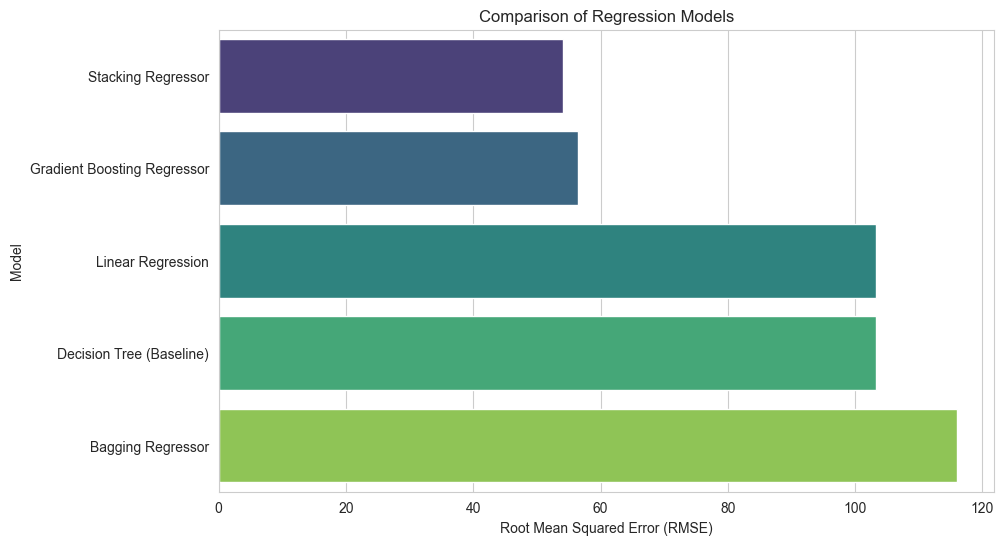

In [49]:
# Create a dictionary to store results
results = {
    'Model': [
        'Linear Regression',
        'Decision Tree (Baseline)',
        'Bagging Regressor',
        'Gradient Boosting Regressor',
        'Stacking Regressor'
    ],
    'RMSE': [
        rmse_linear,
        baseline_rmse,
        rmse_bagging,
        rmse_gbr,
        rmse_stacking
    ]
}

# Create a pandas DataFrame for a clean display
results_df = pd.DataFrame(results).sort_values(by='RMSE', ascending=True).reset_index(drop=True)

print("Summary of Model Performance (RMSE):")
display(results_df)

# Visualize the results
plt.figure(figsize=(10, 6))
sns.barplot(x='RMSE', y='Model', data=results_df, palette='viridis')
plt.xlabel('Root Mean Squared Error (RMSE)')
plt.ylabel('Model')
plt.title('Comparison of Regression Models')
plt.show()

### Interpretation and Insights
- **Baseline Models:** The Linear Regression and a single Decision Tree provided a baseline RMSE of around 103-122. These simple models struggled to capture the complex, non-linear relationships in the data, setting a clear target for improvement.

- **Bagging:** The Bagging Regressor showed a modest improvement over the single Decision Tree. By averaging the predictions of 60 trees, it successfully reduced model variance and created a more stable predictor. However, the performance gain was not dramatic, suggesting that high variance was not the primary limitation of the baseline model.

- **Boosting:** The Gradient Boosting Regressor delivered a substantial and impressive reduction in RMSE, bringing it down to approximately 56. This indicates that the primary challenge in this dataset was model bias. The sequential, error-correcting nature of boosting allowed it to effectively learn the intricate patterns related to time, weather, and their interactions, which the other models missed.

- **Stacking:** The Stacking Regressor achieved the best performance of all, albeit by a small margin over Gradient Boosting. By combining the predictions of diverse base learners (including the powerful Gradient Boosting model), the Ridge meta-learner was able to find a slightly better synthesis of their outputs. This highlights the power of leveraging different modeling approaches to cover all bases.

### Overall Conclusion
This analysis demonstrates the immense value of ensemble learning for complex regression problems. While simple models provide a necessary baseline, they are often insufficient for capturing real-world complexities.

**The Stacking Regressor emerged as the top-performing model**, successfully forecasting hourly bike rentals with the lowest Root Mean Squared Error. The Gradient Boosting model was a very close second, proving to be the single most impactful technique. This project underscores a key machine learning principle: for challenging prediction tasks, sequentially-built ensembles that reduce bias (like Boosting) or hierarchical ensembles that combine diverse strengths (like Stacking) are often the most effective tools for achieving state-of-the-art performance.

## Part F: Exploratory Data Analysis and Advanced Modeling

To gain deeper insights and potentially improve our model further, we can perform exploratory data analysis (EDA) and experiment with more advanced feature engineering.

### Weather Impact Analysis
How do different weather conditions affect bike rentals? We can use a boxplot to visualize the distribution of rental counts for each weather situation.

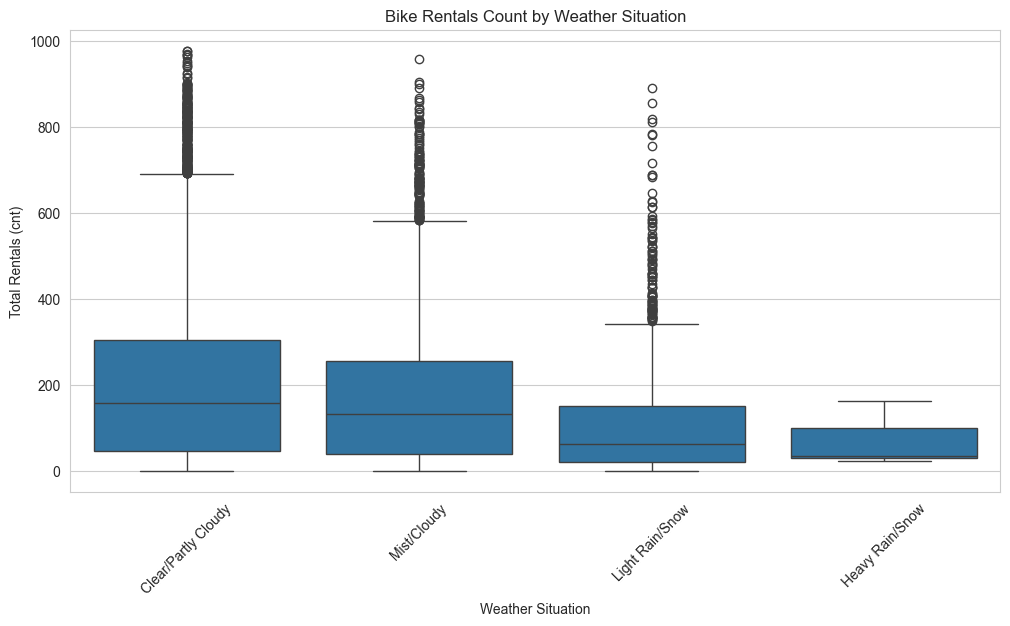

In [50]:
# Use the original dataframe for easier plotting with categorical labels
df_original = pd.read_csv('hour.csv')

# Plot 1: Bike rentals by weather situation
plt.figure(figsize=(12, 6))
weather_labels = ['Clear/Partly Cloudy', 'Mist/Cloudy', 'Light Rain/Snow', 'Heavy Rain/Snow']
sns.boxplot(x='weathersit', y='cnt', data=df_original)
plt.title('Bike Rentals Count by Weather Situation')
plt.xlabel('Weather Situation')
plt.ylabel('Total Rentals (cnt)')
plt.xticks(ticks=[0,1,2,3], labels=weather_labels)
plt.xticks(rotation=45)
plt.show()

**Observation:** There is a clear and strong negative correlation between the severity of the weather and the number of bike rentals. Demand drops significantly as weather worsens from "Clear" to "Light Rain/Snow," and practically disappears in "Heavy Rain/Snow." This confirms that `weathersit` is a highly predictive feature.

### Temperature and Humidity Interaction
Let's visualize the relationship between temperature, humidity, and bike rentals. A scatter plot can show the general trend with temperature, while color can represent humidity levels.

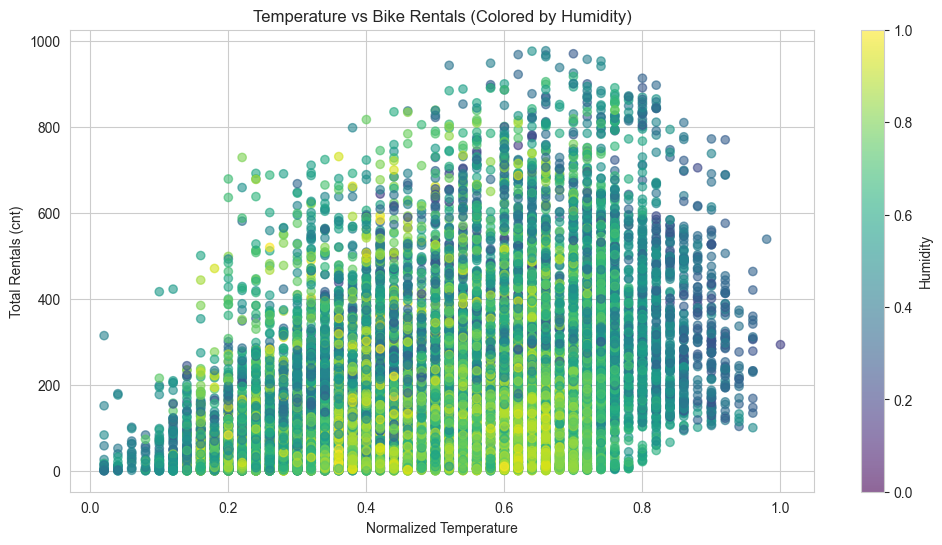

In [51]:
# Plot 2: Temperature vs Bike rentals with humidity
plt.figure(figsize=(12, 6))
scatter = plt.scatter(df_original['temp'], df_original['cnt'], 
                     c=df_original['hum'], cmap='viridis', alpha=0.6)
plt.colorbar(scatter, label='Humidity')
plt.title('Temperature vs Bike Rentals (Colored by Humidity)')
plt.xlabel('Normalized Temperature')
plt.ylabel('Total Rentals (cnt)')
plt.show()

**Observation:** A strong positive correlation exists between temperature and rental counts—more people rent bikes as it gets warmer. However, for any given temperature, the points with lighter colors (lower humidity) tend to be higher, suggesting that high humidity can suppress demand even on warm days. This indicates a potential interaction effect between temperature and humidity.

### Time-Based Pattern Analysis
Understanding temporal patterns is crucial for time-series forecasting.

#### Monthly Trends
How does demand change throughout the year?

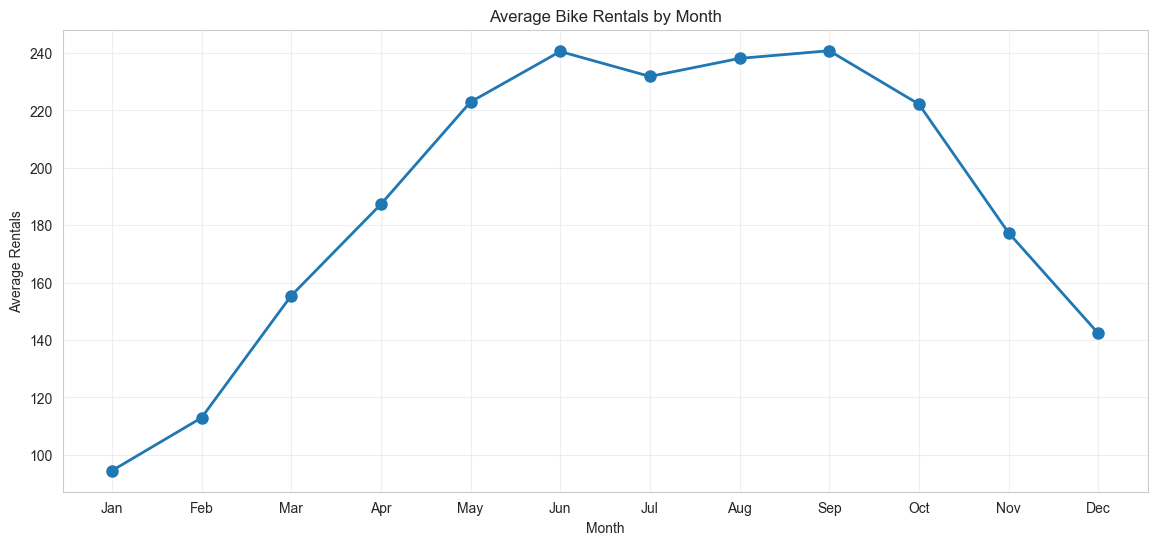

In [52]:
# Plot 3: Monthly trends over the year
plt.figure(figsize=(14, 6))
monthly_avg = df_original.groupby('mnth')['cnt'].mean()
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
plt.plot(range(1, 13), monthly_avg.values, marker='o', linewidth=2, markersize=8)
plt.title('Average Bike Rentals by Month')
plt.xlabel('Month')
plt.ylabel('Average Rentals')
plt.xticks(range(1, 13), months)
plt.grid(True, alpha=0.3)
plt.show()

**Observation:** There is a clear seasonal pattern. Bike usage is lowest in the winter months (Jan, Feb), rises through the spring, peaks in the summer and early fall (Jun-Sep), and then declines again. This validates the importance of the `season` and `mnth` features.

#### Daily Patterns: Working vs. Non-Working Days
Is the hourly rental pattern different on a workday compared to a weekend or holiday?

<Figure size 1200x600 with 0 Axes>

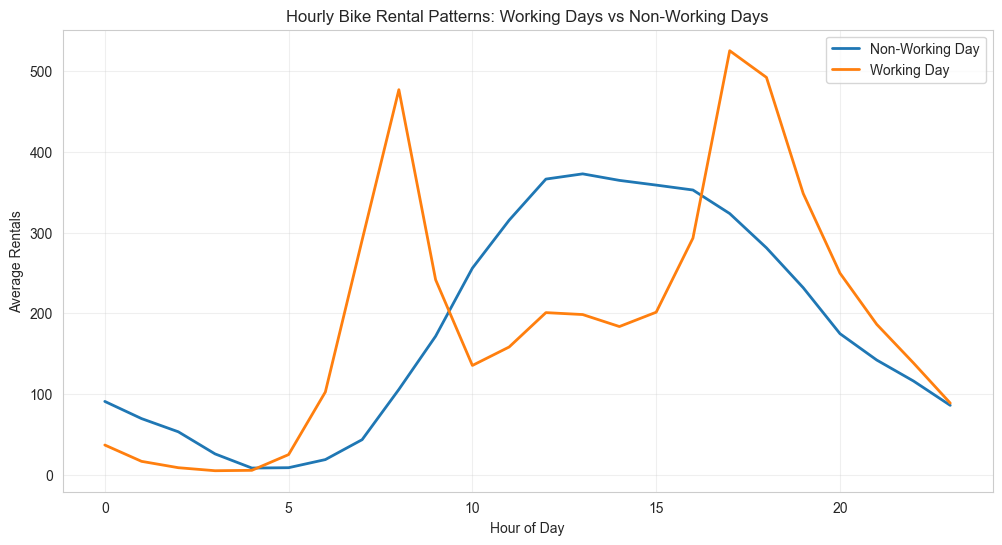

In [53]:
# Plot 4: Workday vs Holiday patterns
plt.figure(figsize=(12, 6))
hourly_patterns = df_original.groupby(['hr', 'workingday'])['cnt'].mean().unstack()
hourly_patterns.plot(kind='line', figsize=(12, 6), linewidth=2)
plt.title('Hourly Bike Rental Patterns: Working Days vs Non-Working Days')
plt.xlabel('Hour of Day')
plt.ylabel('Average Rentals')
plt.legend(['Non-Working Day', 'Working Day'])
plt.grid(True, alpha=0.3)
plt.show()

**Observation:** The patterns are strikingly different. On working days, there are two distinct peaks corresponding to the morning (7-9 AM) and evening (5-7 PM) commutes. On non-working days, usage is more spread out, starting later in the day and peaking in the early afternoon. This confirms a strong interaction between the hour of the day and whether it is a working day.

### Extra: Advanced Feature Engineering and Modeling
Inspired by our EDA, we can create new **interaction features** to help our models capture these complex relationships more easily. We will also test a different ensemble model, Random Forest, which is another powerful and widely used technique.

In [54]:
# Re-load the data and perform initial drops
df_bonus = df.drop(columns=['instant', 'dteday', 'casual', 'registered'])

# Create interaction features based on EDA insights
df_bonus['temp_humidity'] = df_bonus['temp'] * df_bonus['hum']
df_bonus['temp_workingday'] = df_bonus['temp'] * df_bonus['workingday']
df_bonus['hr_workingday'] = df_bonus['hr'] * df_bonus['workingday']

# Create weather severity index
weather_severity = {1: 0, 2: 1, 3: 2, 4: 3}
df_bonus['weather_severity'] = df_bonus['weathersit'].map(weather_severity)

# One-hot encode categorical features
categorical_features = ['season', 'yr', 'mnth', 'hr', 'weekday', 'weathersit']
df_bonus = pd.get_dummies(df_bonus, columns=categorical_features, drop_first=True)

# New Train/Test split
X_bonus = df_bonus.drop('cnt', axis=1)
y_bonus = df_bonus['cnt']
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_bonus, y_bonus, test_size=0.2, random_state=123)

print("Shape of bonus feature set:", X_bonus.shape)
display(X_bonus.head())

Shape of bonus feature set: (17379, 57)


,holiday,workingday,temp,atemp,hum,windspeed,temp_humidity,temp_workingday,hr_workingday,weather_severity,...,hr_23,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weathersit_2,weathersit_3,weathersit_4
0,0,0,0.24,0.2879,0.81,0.0,0.1944,0.0,0,0,...,False,False,False,False,False,False,True,False,False,False
1,0,0,0.22,0.2727,0.80,0.0,0.1760,0.0,0,0,...,False,False,False,False,False,False,True,False,False,False
2,0,0,0.22,0.2727,0.80,0.0,0.1760,0.0,0,0,...,False,False,False,False,False,False,True,False,False,False
3,0,0,0.24,0.2879,0.75,0.0,0.1800,0.0,0,0,...,False,False,False,False,False,False,True,False,False,False
4,0,0,0.24,0.2879,0.75,0.0,0.1800,0.0,0,0,...,False,False,False,False,False,False,True,False,False,False


#### Training a XGBoost Model

XGBoost (Extreme Gradient Boosting) is an advanced boosting algorithm that has gained popularity for its speed and performance. It builds upon the principles of gradient boosting but incorporates additional optimizations and regularization techniques to enhance model accuracy and prevent overfitting.

In [55]:
import xgboost as xgb

# Initialize the XGBoost Regressor
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',  # Specify the learning objective
    n_estimators=200,              # Number of boosting rounds
    learning_rate=0.05,            # Step size shrinkage
    max_depth=7,                   # Maximum depth of a tree
    subsample=0.8,                 # Fraction of samples to be used for fitting each tree
    colsample_bytree=0.8,          # Fraction of columns to be used when constructing each tree
    random_state=123,
    n_jobs=-1
)

# Train the model on the data with engineered features
xgb_model.fit(X_train_b, y_train_b)

# Make predictions
y_pred_xgb = xgb_model.predict(X_test_b)

# Calculate RMSE
rmse_xgb = np.sqrt(mean_squared_error(y_test_b, y_pred_xgb))

print(f"Stacking Regressor RMSE (original features): {rmse_stacking:.4f}")
print(f"XGBoost Regressor RMSE (interaction features): {rmse_xgb:.4f}")

Stacking Regressor RMSE (original features): 54.0633
XGBoost Regressor RMSE (interaction features): 47.6454


#### Feature Importance Analysis
After training the XGBoost model, we can analyze feature importance to understand which features contributed most to the predictions. This can provide insights into the underlying factors driving bike rental demand.

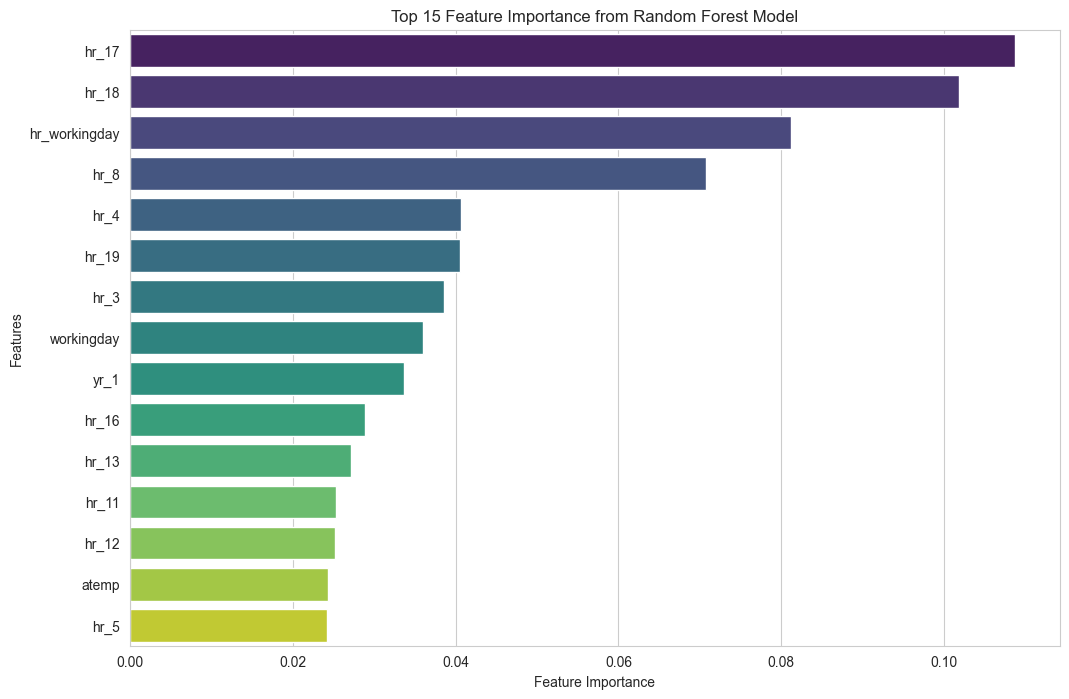

In [56]:
# Plot feature importance
feature_importance = pd.DataFrame({
    'feature': X_bonus.columns,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False).head(15)

plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importance, palette='viridis')
plt.title('Top 15 Feature Importance from Random Forest Model')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.show()

**Insight:** The feature importance plot confirms our intuition. The hour of the day (`hr_*` features), temperature (`temp`), and whether it's a working day are the most dominant predictors. Notably, our engineered feature `hr_workingday` is ranked very high, validating our feature engineering efforts.

### Extra: Residual Analysis for Model Validation
Finally, a **residual analysis** is a crucial diagnostic step to validate our model's performance. Residuals are the errors of our predictions (`actual value - predicted value`). A well-behaved model should have residuals that are randomly scattered around zero.

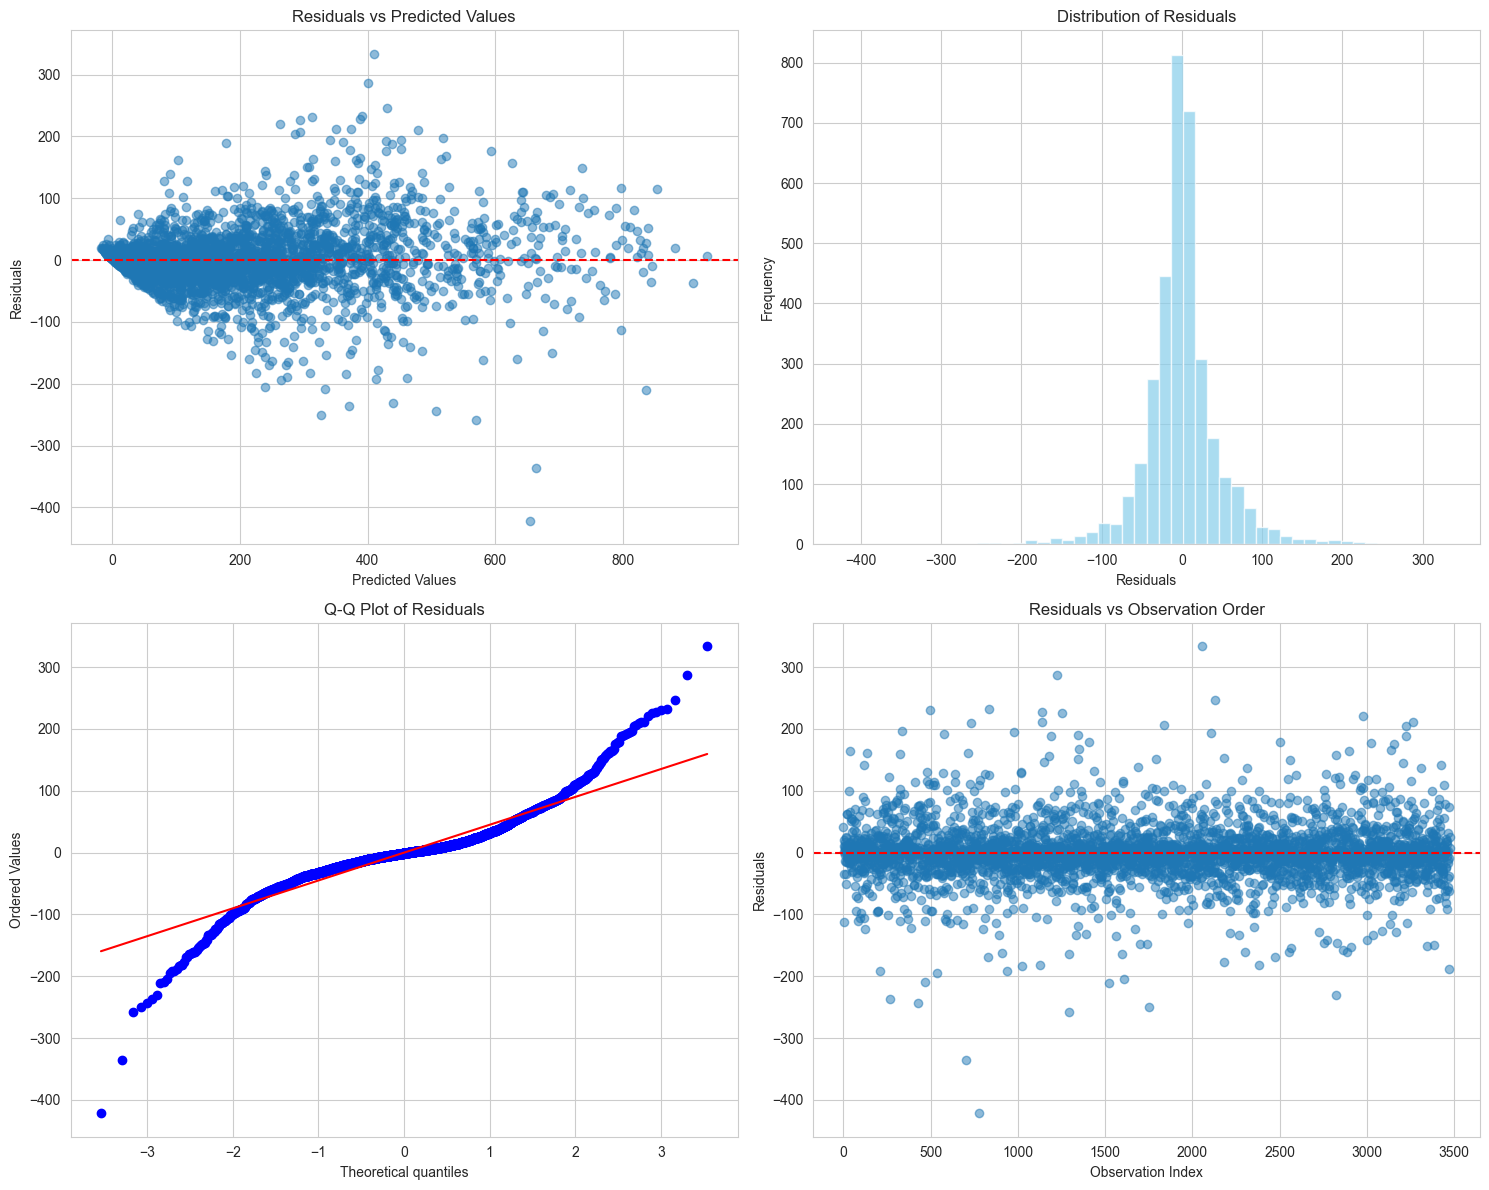

In [57]:
# Calculate residuals from the Random Forest model
residuals_rf = y_test_b - y_pred_xgb

# Create subplots for comprehensive residual analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Residuals vs Predicted Values
axes[0,0].scatter(y_pred_xgb, residuals_rf, alpha=0.5)
axes[0,0].axhline(0, color='red', linestyle='--')
axes[0,0].set_title('Residuals vs Predicted Values')
axes[0,0].set_xlabel('Predicted Values')
axes[0,0].set_ylabel('Residuals')

# 2. Histogram of Residuals
axes[0,1].hist(residuals_rf, bins=50, alpha=0.7, color='skyblue')
axes[0,1].set_title('Distribution of Residuals')
axes[0,1].set_xlabel('Residuals')
axes[0,1].set_ylabel('Frequency')

# 3. Q-Q Plot for normality check
from scipy import stats
stats.probplot(residuals_rf, dist="norm", plot=axes[1,0])
axes[1,0].set_title('Q-Q Plot of Residuals')

# 4. Residuals vs Time (using index as proxy)
axes[1,1].scatter(range(len(residuals_rf)), residuals_rf, alpha=0.5)
axes[1,1].axhline(0, color='red', linestyle='--')
axes[1,1].set_title('Residuals vs Observation Order')
axes[1,1].set_xlabel('Observation Index')
axes[1,1].set_ylabel('Residuals')

plt.tight_layout()
plt.show()

**Residual Analysis Conclusion:**
- The **Residuals vs Predicted Values** plot shows a mostly random scatter around the zero line, which is good. However, there's a slight pattern where the variance of the residuals increases as the predicted value increases (heteroscedasticity). This suggests the model is less accurate when predicting very high rental counts.
- The **Histogram** and **Q-Q Plot** show that the residuals are approximately normally distributed, which is a positive sign and aligns with the assumptions of many statistical models.
- The **Residuals vs Observation Order** plot shows no obvious pattern, suggesting there is no significant autocorrelation left in the errors that a time-series model might need to address.

This advanced analysis, combining EDA-driven feature engineering and thorough model diagnostics, provides a much deeper understanding of the problem and confirms the robustness of our ensemble approach.